# Shadow Removal

## Setup

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

import closed_form_matting

## Input Image and Build Soft Mask through Matting

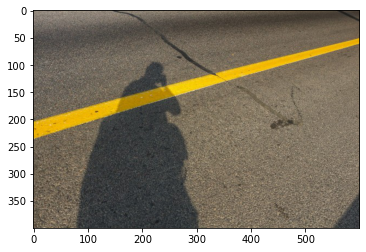

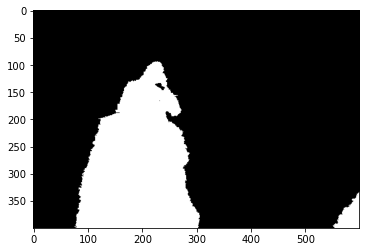

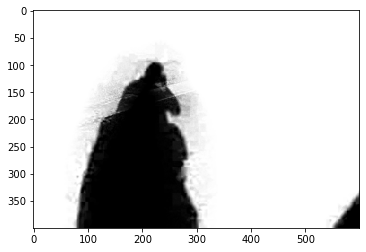

In [2]:
#309834_600
#87563
#338398251_04f8821e2e_z



#0_90968_12d98a11_XL
#DSCF4142


#road_shadow


shadow_img = cv2.cvtColor(cv2.imread('Samples/ShadowImages/road_shadow.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(shadow_img)
plt.show()


hard_mask = cv2.cvtColor(cv2.imread('Samples/HardMasks/road_shadow.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(hard_mask)
plt.show()

scribbles = cv2.imread('Samples/Scribbles/road_shadow.png', cv2.IMREAD_COLOR) / 255.0
soft_mask = closed_form_matting.closed_form_matting_with_scribbles(shadow_img, scribbles)


cv2.imwrite('Samples/SoftMasks/road_shadow.png', soft_mask * 255.0)


soft_mask = cv2.cvtColor(cv2.imread('Samples/SoftMasks/road_shadow.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

soft_mask = 1 - soft_mask

plt.imshow(soft_mask)
plt.show()



## Functions for Shadow Removal

In [3]:
def computeAverage(arr):
    arr[arr == 0] = np.nan
    arr_mean = np.nanmean(arr, axis=1)
    arr_mean = np.nanmean(arr_mean, axis=0)

    return arr_mean

def getIntensityRatio(imgPatch, maskPatch, softMaskPatch):
    
    s = imgPatch
    m = maskPatch
    
    shd = s*m
    non_shd = s*np.logical_not(m)

    shd_mean = computeAverage(shd)
    non_shd_mean = computeAverage(non_shd)
    
    
    shd_K = softMaskPatch*m
    non_shd_K = softMaskPatch*np.logical_not(m)

    shd_mean_K = computeAverage(shd_K)
    non_shd_mean_K = computeAverage(non_shd_K)
    
    

    r = (non_shd_mean - shd_mean) / ((shd_mean*non_shd_mean_K) - (non_shd_mean*shd_mean_K))
    
    
    return r



def getMaskRatio(m):
    
    totalCount = m.shape[0]*m.shape[1]
    
    
    mOnes = np.count_nonzero(m[:,:,0]) 
    mZeros = totalCount - mOnes
    
    
    patchRatio = mOnes  / (mOnes + mZeros)
    
    return patchRatio



def getPatch(soft_mask, hard_mask, shadow_img, x, y, patch_size, width, height):

    xE = x + patch_size
    yE = y + patch_size
    
    if(xE >= height):
        xE = xE - (xE - height + 1)

    if(yE >= width):
        yE = yE - (yE - width + 1)
        
    soft_m = soft_mask[x:xE, y:yE,:].copy()
    
    m = hard_mask[x:xE, y:yE,:].copy()
    
    s = shadow_img[x:xE, y:yE,:].copy() 
    
    maskRatio = getMaskRatio(m) 
    
    if(maskRatio > 0.49 and maskRatio < 0.51):
        return s, m, soft_m, True
    else:
        return None, None, None, False
        
    
    
def updateBins(bins, binIndx, r):
    
    for i in range(3):
        currentR = round(r[i], 1)
        
        if(0 <= int(currentR*10) and int(currentR*10) < len(binIndx)):
            bins[int(currentR*10), i]  = bins[int(currentR*10),i] + 1
        
    return bins


def getFinalRatio(bins, binIndx):
    
    r = np.zeros(3).astype('float64')

    indx = np.where(bins == np.max(bins, axis=0))
    
    prevY = 0
    prevYCount = 0
    
    for x, y in zip(indx[0], indx[1]):
        
        r[y] = r[y] + binIndx[x].astype('float64')
        
        r = np.nan_to_num(r)
        
        if(y != prevY):
            r[prevY]  = r[prevY]/prevYCount
            prevYCount = 0
            
        prevY  = y
        prevYCount = prevYCount + 1
    
    r[prevY]  = r[prevY]/prevYCount
    
    return r
        
    
def removeShadowImage(shadow_img, hard_mask, softMaskPatch, ratio):
    
    shadow_mapper = (ratio + 1)/(ratio*softMaskPatch + 1)
    
    
    mapped_image = np.multiply(shadow_img, shadow_mapper)

    max_vals = np.zeros(3, dtype= 'float64')
    max_valsBG = np.zeros(3, dtype= 'float64')


    fg = (hard_mask*mapped_image)
    
    bg = shadow_img*np.logical_not(hard_mask)


    max_vals[0]  = np.amax(fg[:,:,0])
    max_vals[1]  = np.amax(fg[:,:,1])
    max_vals[2]  = np.amax(fg[:,:,2])
    
    max_valsBG[0]  = np.amax(bg[:,:,0])
    max_valsBG[1]  = np.amax(bg[:,:,1])
    max_valsBG[2]  = np.amax(bg[:,:,2])

    shadow_free_image = (fg/max_vals) + (shadow_img*np.logical_not(hard_mask))
    
    return shadow_free_image



def fixPatchShadow(imgPatch, maskPatch, softMaskPatch, ratio):
    
    mapper = (ratio + 1)/(ratio*softMaskPatch + 1)
    
    fixed = imgPatch*mapper
    
    fg = fixed*maskPatch

    
    bg = fixed*np.logical_not(maskPatch)

    
    final = (fg)+bg
    
    return final


def rescale_images_linear(le):
    '''
    Helper function to rescale images in visible range
    '''
    le_min = le[le != -float('inf')].min()
    le_max = le[le != float('inf')].max()
    le[le==float('inf')] = le_max
    le[le==-float('inf')] = le_min

    le = (le - le_min) / (le_max - le_min)

    return le

In [10]:
def shadowRemover(shadow_img, soft_mask, hard_mask, patch_size = 12, offset = 1):


    height = shadow_img.shape[0]
    width = shadow_img.shape[1]


    binIndx = np.arange(0,100,0.1)
    bins = np.zeros((len(binIndx),3))



    for x in np.arange(0,height,offset)[0:-1]:
        for y in np.arange(0,width,offset)[0:-1]:


            s, m, soft_m, check = getPatch(soft_mask, hard_mask, shadow_img, x, y, patch_size, width, height)

            if(check):

                r = getIntensityRatio(s, m, soft_m)

                bins = updateBins(bins, binIndx, r)



    r = getFinalRatio(bins, binIndx)

    shadow_free_image = fixPatchShadow(shadow_img.copy(), hard_mask.copy(), soft_mask.copy(), r)
    
    
    return shadow_free_image, bins, r





## Results

/Users/muhammadrafay/opt/miniconda3/envs/cs445/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/muhammadrafay/opt/miniconda3/envs/cs445/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in double_scalars


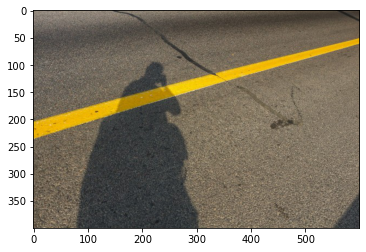

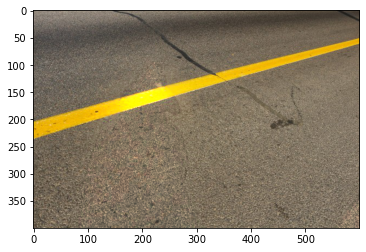

Final RGB Ratios: [1.4 1.  0.6]


In [11]:

shadow_free_image, bins, r = shadowRemover(shadow_img, soft_mask, hard_mask, 80, 1)

plt.figure()
plt.imshow(shadow_img)
plt.show()

plt.figure()
plt.imshow(shadow_free_image)
plt.savefig('Results/road_shadow.png', dpi = 300)
plt.show()


print('Final RGB Ratios:', r)


(0.0, 30.0)

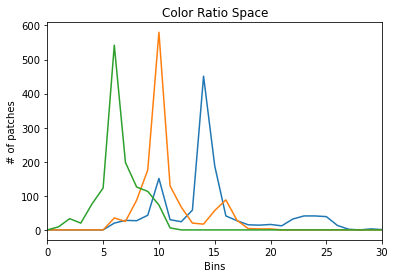

In [82]:
plt.figure()
plt.title('Color Ratio Space')
plt.xlabel("Bins")
plt.ylabel("# of patches")
plt.plot(bins)
plt.xlim([0, 30])
